In [1]:
import pandas as pd
import json
import numpy as np
import datetime
from datetime import timedelta
from dateutil import parser

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier, cv, plot_importance

from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

# %matplotlib inline

In [2]:
login_df = pd.read_json('logins.json')

In [3]:
login_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


## Part 1 ‐ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15-minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

#### Step 1: Explore the data

In [4]:
print('Data Date Range: ', min(login_df['login_time']), '-', max(login_df['login_time']))
print('Time Entries: ', len(login_df['login_time']))

Data Date Range:  1970-01-01 20:12:16 - 1970-04-13 18:57:38
Time Entries:  93142


In [5]:
login_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [6]:
login_df.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


#### Step 2: Aggregate login counts based on 15-minute time intervals

In [7]:
login_df.set_index('login_time', inplace=True)
login_df['count'] = 1
login_df.sort_index(inplace=True)
login_agg_df = login_df.resample("15min").sum()

In [8]:
login_agg_df.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [9]:
print(len(login_df))
len(login_df) == login_agg_df['count'].sum()

93142


True

#### Step 3:  Visualize and Describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand

In [10]:
login_agg_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15T
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   count   9788 non-null   int64
dtypes: int64(1)
memory usage: 152.9 KB


In [11]:
login_agg_df.describe()

,count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


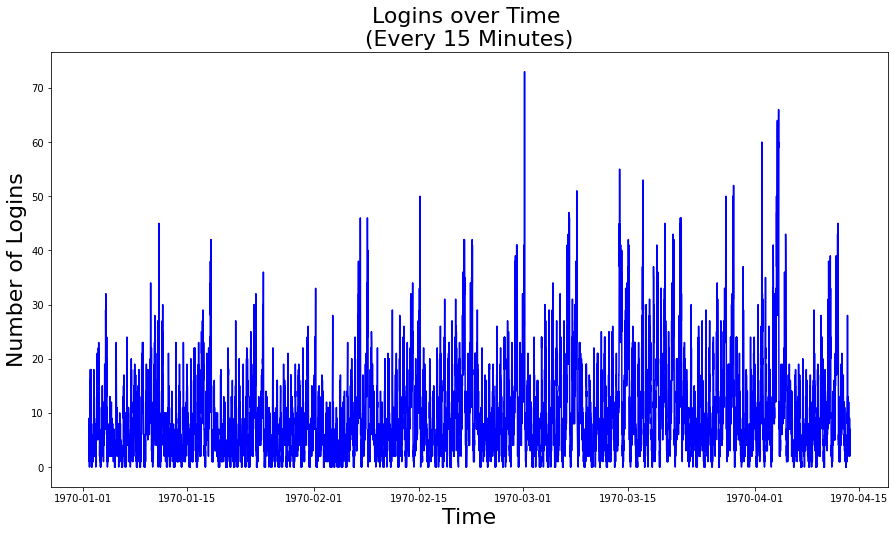

In [12]:
fig, ax = plt.subplots(figsize = (15,8))
plt.xlabel('Time', fontsize = 22)
plt.ylabel('Number of Logins', fontsize = 22)
plt.title('Logins over Time \n(Every 15 Minutes)', fontsize = 22)


plt.plot(login_agg_df.index, login_agg_df['count'], label = 'Daily Frequencies', color = 'b')

plt.show()

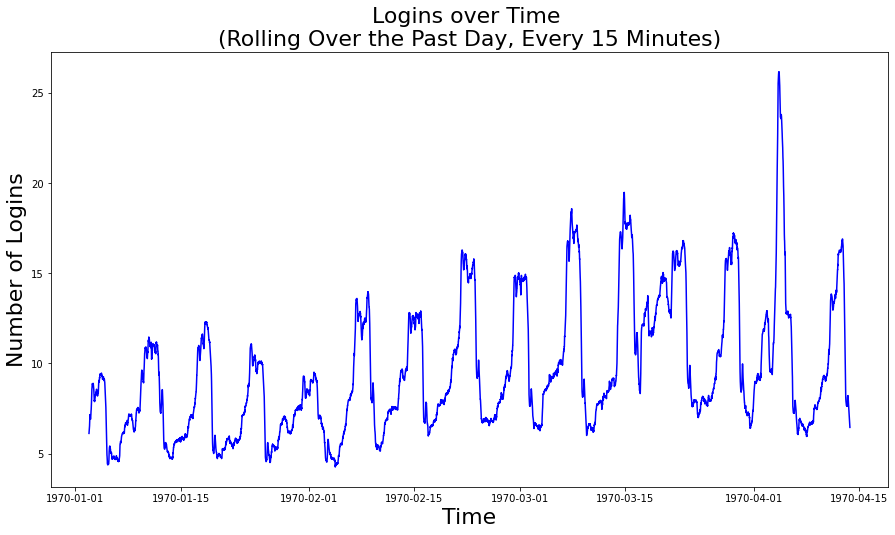

In [13]:
window = int(60*24/15) # 60 min * 24 hours / aggragation rate 15 min 

fig, ax = plt.subplots(figsize = (15,8))
plt.xlabel('Time', fontsize = 22)
plt.ylabel('Number of Logins', fontsize = 22)
plt.title('Logins over Time \n(Rolling Over the Past Day, Every 15 Minutes)', fontsize = 22)


plt.plot(login_agg_df.index, login_agg_df.rolling(window=window).mean(), label = 'Daily Frequencies', color = 'b')

plt.show()

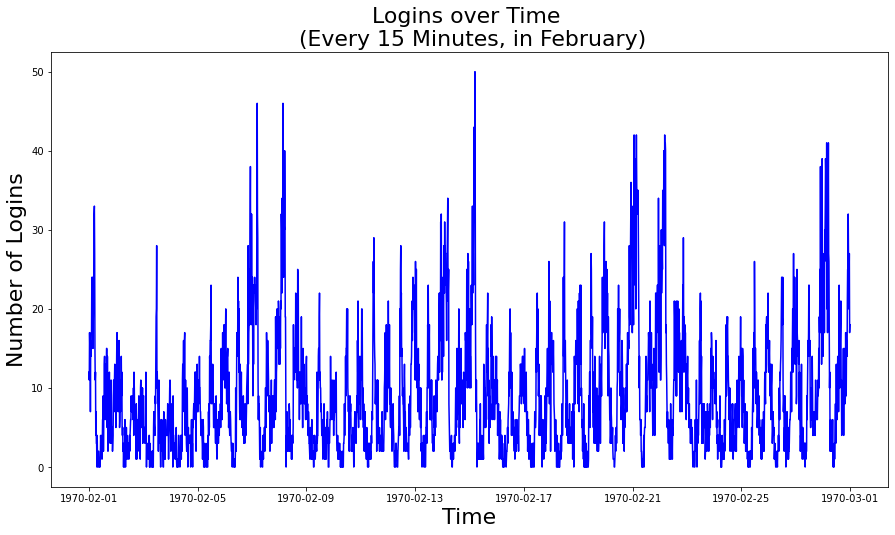

In [14]:
fig, ax = plt.subplots(figsize = (15,8))
plt.xlabel('Time', fontsize = 22)
plt.ylabel('Number of Logins', fontsize = 22)
plt.title('Logins over Time \n (Every 15 Minutes, in February)', fontsize = 22)

plt.plot(login_agg_df.loc['1970-02'].index, login_agg_df.loc['1970-02']['count'], label = 'Daily Frequencies', color = 'b')

plt.show()

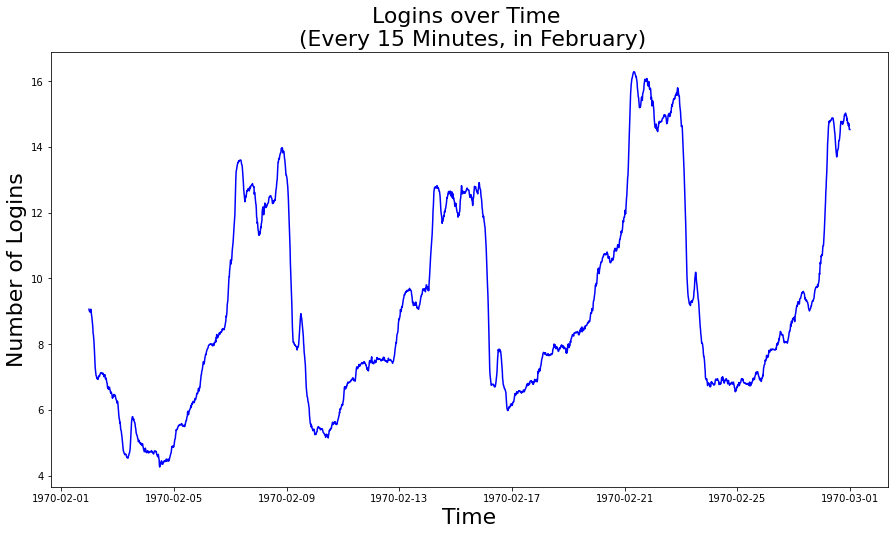

In [15]:
fig, ax = plt.subplots(figsize = (15,8))
plt.xlabel('Time', fontsize = 22)
plt.ylabel('Number of Logins', fontsize = 22)
plt.title('Logins over Time \n (Every 15 Minutes, in February)', fontsize = 22)

plt.plot(login_agg_df.loc['1970-02'].index, login_agg_df.loc['1970-02'].rolling(window=window).mean(), label = 'Daily Frequencies', color = 'b')

plt.show()

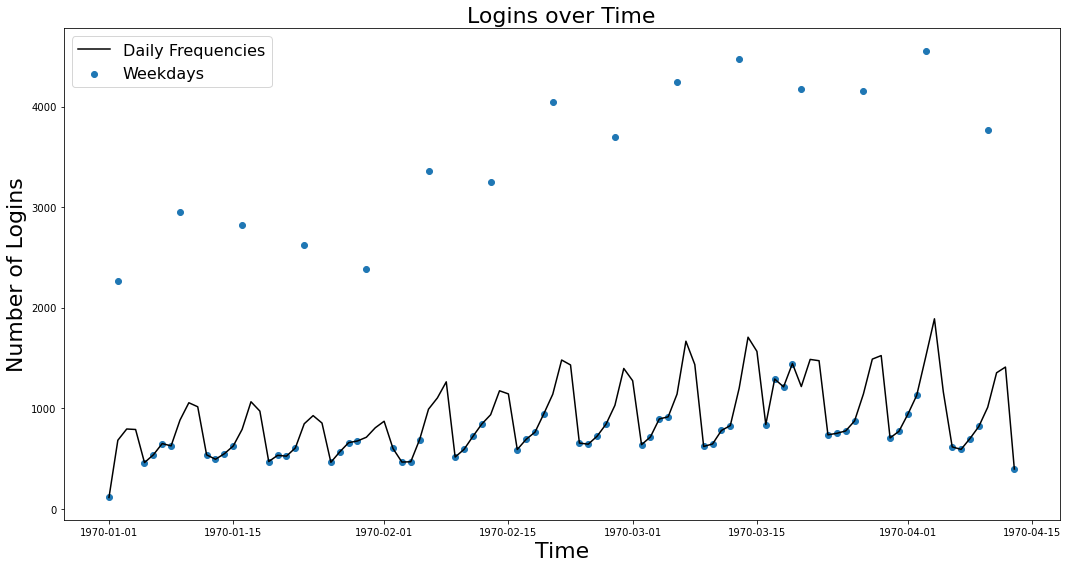

In [16]:
logins_daily = login_df.resample('D').sum()
logins_biz_day = login_df.resample('B').sum()
# fridays = login_df.resample('W-FRI').sum()
# saturdays = login_df.resample('W-SAT').sum()
# sundays = login_df.resample('W-SUN').sum()


# line, scatterplot, and histograms of the binned data
fig, ax = plt.subplots(figsize = (15,8))
plt.xlabel('Time', fontsize = 22)
plt.ylabel('Number of Logins', fontsize = 22)
plt.title('Logins over Time', fontsize = 22)

# plt.bar(fridays.index, fridays['count'], align= 'center', width = 0.2, label = "Fridays", color = 'r')
# plt.bar(saturdays.index, saturdays['count'], label = 'Saturday', align = 'center', width = 0.1, color = 'g')
# plt.bar(sundays.index, sundays['count'], label = "Sundays", align= 'center', width = 0.1, color = 'b')
plt.plot(logins_daily.index, logins_daily['count'], label = 'Daily Frequencies', color = 'k')

plt.scatter(logins_biz_day.index, logins_biz_day['count'], label='Weekdays')

plt.legend(loc='upper left', fontsize = 16)
plt.tight_layout()

[Text(0.5, 0, 'Count by unique day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Days')]

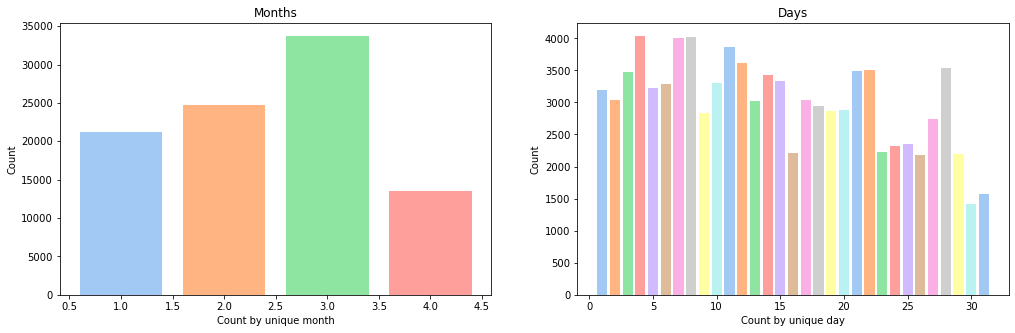

In [17]:
datetimes = list(map(lambda x: x.date(), login_df.index.tolist())) 

months = list(map(lambda x: x.month, datetimes)) 
days = list(map(lambda x: x.day, datetimes))

df_datetimes = pd.DataFrame({'month':months, 'day':days}) 

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(17,5))

# Count by month
month_df = df_datetimes.groupby('month').count()
month_df.head()
ax1.bar(month_df.index, month_df.day, color=sns.color_palette("pastel", len(month_df.index)))
ax1.set(xlabel='Count by unique month', ylabel="Count", title="Months")

# # Count by day
day_df = df_datetimes.groupby('day').count()
ax2.bar(day_df.index, day_df.month, color=sns.color_palette("pastel", len(day_df.index)))
ax2.set(xlabel='Count by unique day', ylabel="Count", title="Days")

## Part 2 ‐ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

The simplest metric would be number of cars *before* the toll reinmbursement and number of cars *after* the toll reinmbursement. We could keep track of the difference in direction of the traffic as it realates to peak hours in each city but we are just going to keep it simple for now as we ease into the problem.

If we see an increase in traffic into either city that means that the  toll reimbursment is creating a large influx of travels over the bridge.

If this is true we can go on the optimize the toll timing say provide reimersments only. during peak hours to allow for an large amount of traffic.

2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
    
    a. how you will implement the experiment
    
    b. what statistical test(s) you will conduct to verify the significance of the observation
    
    c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.
    
    
Again, we will start simple and maybe in the future dive deeper to optimize the preformance of the toll reimersments.

Knowing that our sample sze is greater the 30 driver partners per one full week going both directions we will conduct a one-sided, 1-sample z-test. We will count the number of cars that cross the bridge during a full week *before* and  *after* the reimbursement are introduced.

H0: After toll reimbursement are introduced, there was no difference in the number of driver partners that crossed the bridge during the full week.
H1:  After toll reimbursement are introduced, there was an increase in the number of driver partners that crossed the bridge during the full week.

The null hypothesis distribution is the distribution of driver partners that crossed the bridge before toll reimbursement were introduced.


To find the z-score of average frequency of driver partners serving both cities, we would use number of driver partners that crossed the bridge after the reimbursement took place. Set the significance threshold to 0.05 then determine if z-score's p-value falls below this significance threshold. If the p-value is less than our set significant threshold than the Null hyypothises fails and we can accecpt our hypothesis were increase in bridge crossings after the reimbursment was caused by the toll reimbursements

As a result of the experiment, we recommend a deeper dive into the optimizing of the time at which the tolls are used to generate higher driver movent into the citys. As for using tolls reimursments now, please do the toll reimbersement does cause an increase in the driver partners traffic and will create a larger econmoic impate on the cities. 


## Part 3 ‐ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

In [18]:
users_df = pd.read_json('ultimate_data_challenge.json')

In [19]:
users_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [20]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [21]:
users_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000



#### Step 1: Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?


In [22]:
# User is retained if the. user is still active after 30 days so we will trim off the last 30 days.
 
# convert all dates to datetime
users_df['signup_date'] = pd.to_datetime(users_df['signup_date'])
users_df['last_trip_date'] = pd.to_datetime(users_df['last_trip_date'])

# add dummies to categorical data
users_df = pd.get_dummies(users_df, columns = ['city', 'phone'])

# latest date
date_pulled = max(users_df['last_trip_date']) # get max = approximation of when data was pulled

# last 30 days for earliest active date, to meet the retained criteria
cutoff = date_pulled - timedelta(days=30)

print("last retained date: ", cutoff)






last retained date:  2014-06-01 00:00:00


In [23]:
# how many users were retained vs total users registered
users_df['active'] = (users_df['last_trip_date'] > cutoff).astype('int')

print(users_df['active'])

 
print('total users registered:', len(users_df))
print('total users retained and active:', len(users_df[users_df['active'] == 1]))
print('users retained and active vs registered:', len(users_df[users_df['active'] == 1])/len(users_df))

0        1
1        0
2        0
3        1
4        0
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: active, Length: 50000, dtype: int64
total users registered: 50000
total users retained and active: 18310
users retained and active vs registered: 0.3662


In [24]:
active_user_df = users_df[users_df.active == 1]
inactive_user_df = users_df[users_df.active == 0]

In [25]:
users_df.columns

Index(['trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'surge_pct', 'ultimate_black_user',
       'weekday_pct', 'avg_dist', 'avg_rating_by_driver', 'city_Astapor',
       'city_King's Landing', 'city_Winterfell', 'phone_Android',
       'phone_iPhone', 'active'],
      dtype='object')

In [26]:
users_df.trips_in_first_30_days


0         4
1         0
2         3
3         9
4        14
         ..
49995     0
49996     1
49997     0
49998     2
49999     0
Name: trips_in_first_30_days, Length: 50000, dtype: int64

In [27]:
users_df.last_trip_date


0       2014-06-17
1       2014-05-05
2       2014-01-07
3       2014-06-29
4       2014-03-15
           ...    
49995   2014-06-05
49996   2014-01-25
49997   2014-05-22
49998   2014-01-15
49999   2014-04-20
Name: last_trip_date, Length: 50000, dtype: datetime64[ns]

In [28]:
users_df.avg_rating_of_driver

0        4.7
1        5.0
2        4.3
3        4.6
4        4.4
        ... 
49995    5.0
49996    NaN
49997    5.0
49998    3.0
49999    NaN
Name: avg_rating_of_driver, Length: 50000, dtype: float64

In [29]:
feature_columns = [
    "trips_in_first_30_days",
    "avg_dist", 
    "avg_rating_by_driver", 
    "avg_rating_of_driver", 
    "avg_surge",
    "surge_pct", 
    "ultimate_black_user", 
    "weekday_pct",
    "city_Astapor", 
    "city_King's Landing", 
    "city_Winterfell", 
    "phone_Android",
    "phone_iPhone"
]


stats_dict = {}

for col in feature_columns:
    stats_dict[col] = [active_user_df[col].mean(), active_user_df[col].std(),
                       inactive_user_df[col].mean(),inactive_user_df[col].std()]

In [30]:
stats1_df = pd.DataFrame(stats_dict)
stats1_df.T

,0,1,2,3
trips_in_first_30_days,3.349590,5.020615,1.659167,2.661903
avg_dist,5.118977,4.627946,6.188478,6.213027
avg_rating_by_driver,4.763121,0.324566,4.786876,0.503869
avg_rating_of_driver,4.593364,0.538166,4.607018,0.664816
avg_surge,1.073720,0.163183,1.075367,0.250219
surge_pct,9.128165,15.489344,8.688548,22.132211
ultimate_black_user,0.511141,0.499890,0.299621,0.458099
weekday_pct,62.214604,29.068319,60.181597,40.985698
city_Astapor,0.219661,0.414029,0.394825,0.488821
city_King's Landing,0.344457,0.475204,0.120637,0.325711


In [31]:
stats_df = pd.DataFrame.from_dict(stats_dict, orient='index').rename(columns = {0:'active_mean', 1:'active_std', 2:'inactive_mean', 3:'inactive_std'})

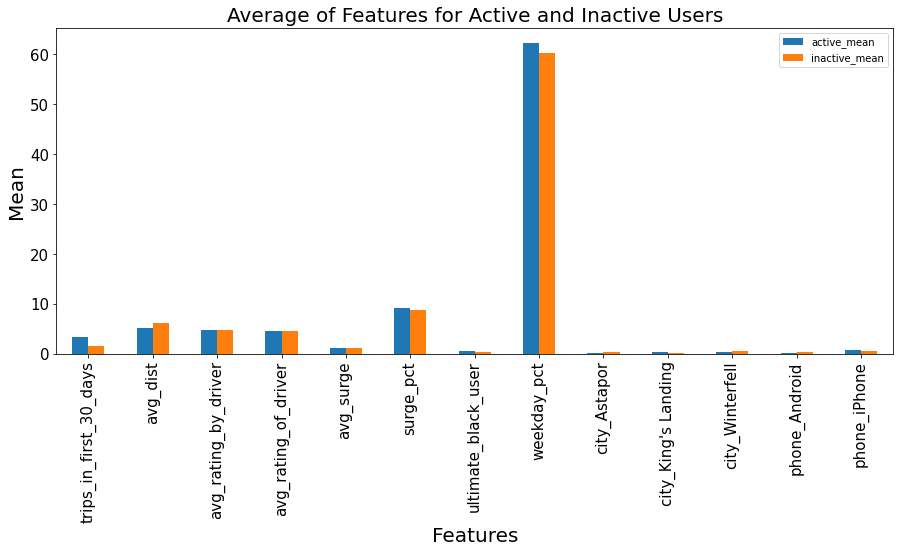

In [32]:
stats_df[['active_mean', 'inactive_mean']].plot(kind = 'bar', yerr=stats_df[['active_std','inactive_std']], figsize = (15,6), fontsize = 15)
plt.xlabel('Features',fontsize = 20)
plt.ylabel('Mean', fontsize = 20)
plt.title('Average of Features for Active and Inactive Users', fontsize = 20)
plt.show()

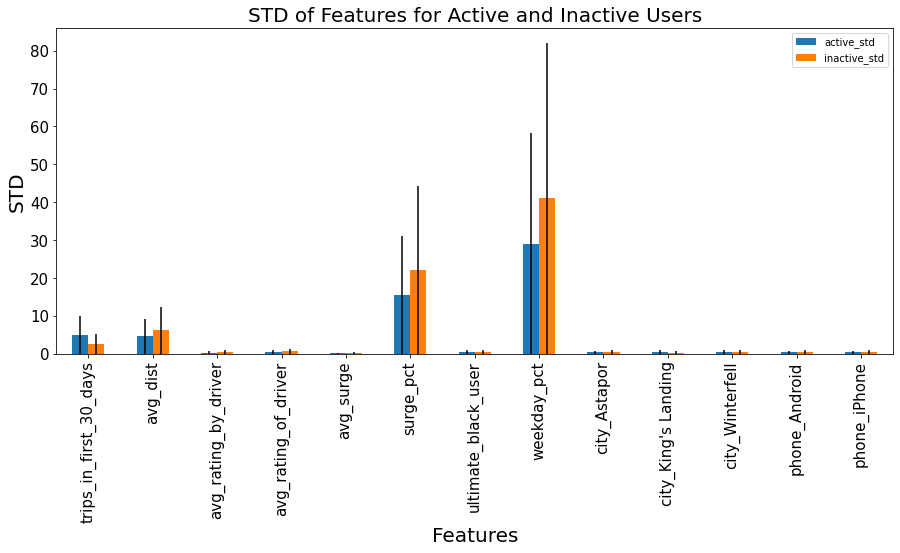

In [33]:
stats_df[['active_std', 'inactive_std']].plot(kind = 'bar', yerr=stats_df[['active_std','inactive_std']], figsize = (15,6), fontsize = 15)
plt.xlabel('Features',fontsize = 20)
plt.ylabel('STD', fontsize = 20)
plt.title('STD of Features for Active and Inactive Users', fontsize = 20)
plt.show()

We can see the charts above show that the ative and inactive datasets are very similar. Not to much of a change from one average to the next and the std are pretty similar too. I can see that a few features standout with higher values so we will normallize the data.  

#### Step2: Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

In [34]:
# start of by splitting of users that have been 
# active for 6 months or (365/6) 183 days

signup_date_plus_six_month = users_df['signup_date'] + timedelta(days=151) 

# users active for 6th month or more
active_goal = [i for i, x in enumerate(users_df['last_trip_date']) if x >= signup_date_plus_six_month[i]] # their their indices in database

users_df['active'] = 0 # set default to 0
users_df.loc[active_goal, 'active'] = 1 # set active users to 1

print("Number of active users: ", len(active_goal))
print("Number of inactive users: ", len(users_df) - len(active_goal))
print("Percent active users: ", len(active_goal)/len(users_df))

Number of active users:  12198
Number of inactive users:  37802
Percent active users:  0.24396


In [35]:
users_df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,active
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,0,1,0,0,1,0
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,1,0,0,1,0,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,1,0,0,0,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,0,1,0,0,1,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,0,0,1,1,0,0


In [36]:
print("ultimate_black_user: ", users_df['ultimate_black_user'].unique())


ultimate_black_user:  [ True False]


In [37]:
# Convert ultimate black status
users_df['ultimate_black_user'] = users_df['ultimate_black_user'].map(lambda b: 1 if b == True else 0)

In [38]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trips_in_first_30_days  50000 non-null  int64         
 1   signup_date             50000 non-null  datetime64[ns]
 2   avg_rating_of_driver    41878 non-null  float64       
 3   avg_surge               50000 non-null  float64       
 4   last_trip_date          50000 non-null  datetime64[ns]
 5   surge_pct               50000 non-null  float64       
 6   ultimate_black_user     50000 non-null  int64         
 7   weekday_pct             50000 non-null  float64       
 8   avg_dist                50000 non-null  float64       
 9   avg_rating_by_driver    49799 non-null  float64       
 10  city_Astapor            50000 non-null  uint8         
 11  city_King's Landing     50000 non-null  uint8         
 12  city_Winterfell         50000 non-null  uint8 

In [39]:
users_df['avg_rating_by_driver'].fillna(users_df['avg_rating_by_driver'].mean(), inplace=True)
users_df['avg_rating_of_driver'].fillna(users_df['avg_rating_of_driver'].mean(), inplace=True)

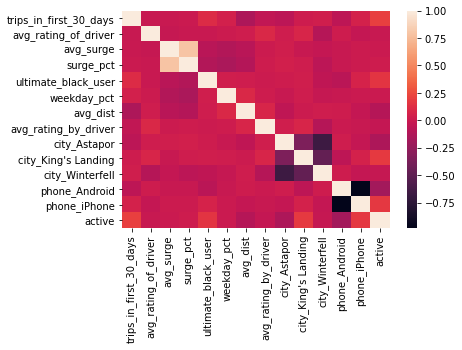

In [40]:
sns.heatmap(users_df.corr());

In [41]:
users_df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,active
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,1,46.2,3.67,5.0,0,1,0,0,1,0
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,0,50.0,8.26,5.0,1,0,0,1,0,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,0,100.0,0.77,5.0,1,0,0,0,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,1,80.0,2.36,4.9,0,1,0,0,1,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,0,82.4,3.13,4.9,0,0,1,1,0,0


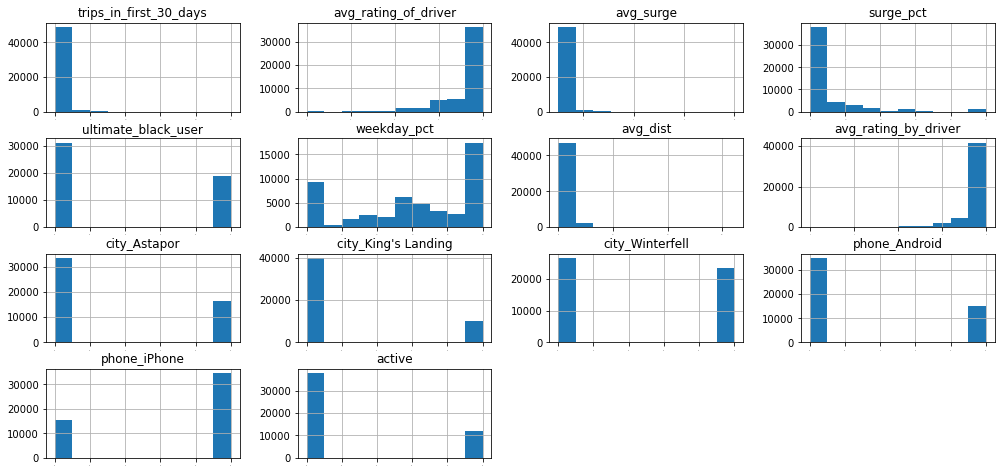

In [42]:
users_df.hist(sharex=False, sharey=False, xlabelsize=1, figsize=(17,8))
plt.show()

We are going to scale our features using MinMaxScaler. This will shrink the range of each feature to (0,1) since there are no negative values. MinMaxScaler works best for data that aren't normally distributed. 

Then we will split the data using train_test_split

In [43]:
X = users_df[feature_columns]
y = users_df.active


scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)


We are going to try 6 different models to see which works the best. 
- Logistic Regression
- Decision Tree
- Random Forest
- Bagging 
- AdaBoost
- XGBoost

### Logistic Regression

In [44]:
model = LogisticRegression() # penalty='l2') # instantiate logreg w/ l regularization
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Model Scoring:', model.score(X, y))
print()

print('Confusion matrix: ')
print(confusion_matrix(y_test, y_pred))
score = accuracy_score(y_test, y_pred)
print()
print('accuracy score:', score)

Model Scoring: 0.76828

Confusion matrix: 
[[10880   426]
 [ 3041   653]]

accuracy score: 0.7688666666666667


### Decision Tree

In [45]:
param_grid = {
    'max_depth':range(2,10)
}


model = DecisionTreeClassifier(min_samples_split=100, max_features='sqrt', random_state=43)
clf = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5)
clf.fit(X_train, y_train)


print(clf.best_params_)
print()
print("Grid scores:")
mean_scores = clf.cv_results_['mean_test_score']
std_scores = clf.cv_results_['std_test_score']
for mean, std, params in zip(mean_scores, std_scores, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
print()
y_true, y_pred = y_test, clf.predict(X_test)

print('Confusion matrix: ')
print(confusion_matrix(y_test, y_pred))
score = accuracy_score(y_test, y_pred)
print()
print('accuracy score:', score)

{'max_depth': 8}

Grid scores:
0.765 (+/-0.002) for {'max_depth': 2}
0.771 (+/-0.008) for {'max_depth': 3}
0.784 (+/-0.004) for {'max_depth': 4}
0.780 (+/-0.003) for {'max_depth': 5}
0.788 (+/-0.006) for {'max_depth': 6}
0.788 (+/-0.005) for {'max_depth': 7}
0.789 (+/-0.009) for {'max_depth': 8}
0.787 (+/-0.007) for {'max_depth': 9}

Confusion matrix: 
[[10364   942]
 [ 2250  1444]]

accuracy score: 0.7872


### Bagging 

In [46]:

param_grid = {
    'n_estimators': range(30, 91, 10)
}

model = BaggingClassifier(random_state=43)
clf = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5)
clf.fit(X_train, y_train)



print(clf.best_params_)
print()
print("Grid scores:")
mean_scores = clf.cv_results_['mean_test_score']
std_scores = clf.cv_results_['std_test_score']
for mean, std, params in zip(mean_scores, std_scores, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
print()
y_true, y_pred = y_test, clf.predict(X_test)

print('Confusion matrix: ')
print(confusion_matrix(y_test, y_pred))
score = accuracy_score(y_test, y_pred)
print()
print('accuracy score:', score)

{'n_estimators': 90}

Grid scores:
0.775 (+/-0.007) for {'n_estimators': 30}
0.777 (+/-0.007) for {'n_estimators': 40}
0.778 (+/-0.007) for {'n_estimators': 50}
0.777 (+/-0.004) for {'n_estimators': 60}
0.778 (+/-0.004) for {'n_estimators': 70}
0.778 (+/-0.004) for {'n_estimators': 80}
0.779 (+/-0.004) for {'n_estimators': 90}

Confusion matrix: 
[[10051  1255]
 [ 2110  1584]]

accuracy score: 0.7756666666666666


### Random Forest 

In [47]:
param_grid = {
    'n_estimators': range(20,91,10), 
    'max_depth': range(2,10), 
    'min_samples_split': range(100,1000,200)
}

model = RandomForestClassifier(random_state=43)
clf = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5)
clf.fit(X_train, y_train)



print(clf.best_params_)
print()
print("Grid scores:")
mean_scores = clf.cv_results_['mean_test_score']
std_scores = clf.cv_results_['std_test_score']
for mean, std, params in zip(mean_scores, std_scores, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
print()
y_true, y_pred = y_test, clf.predict(X_test)

print('Confusion matrix: ')
print(confusion_matrix(y_test, y_pred))
score = accuracy_score(y_test, y_pred)
print()
print('accuracy score:', score)

{'max_depth': 9, 'min_samples_split': 100, 'n_estimators': 90}

Grid scores:
0.757 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 20}
0.757 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 30}
0.757 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 40}
0.757 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 50}
0.757 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 60}
0.757 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 70}
0.757 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 80}
0.757 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 90}
0.757 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 300, 'n_estimators': 20}
0.757 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 300, 'n_estimators': 30}
0.757 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 300, 'n_estimators': 40}

### Ada Boost

In [48]:
param_grid = {
    'n_estimators': range(20, 91, 10)
}
model = AdaBoostClassifier(random_state=43)
clf = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5)
clf.fit(X_train, y_train)



print(clf.best_params_)
print()
print("Grid scores:")
mean_scores = clf.cv_results_['mean_test_score']
std_scores = clf.cv_results_['std_test_score']
for mean, std, params in zip(mean_scores, std_scores, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
print()
y_true, y_pred = y_test, clf.predict(X_test)

print('Confusion matrix: ')
print(confusion_matrix(y_test, y_pred))
score = accuracy_score(y_test, y_pred)
print()
print('accuracy score:', score)

{'n_estimators': 90}

Grid scores:
0.794 (+/-0.004) for {'n_estimators': 20}
0.795 (+/-0.003) for {'n_estimators': 30}
0.796 (+/-0.004) for {'n_estimators': 40}
0.797 (+/-0.005) for {'n_estimators': 50}
0.797 (+/-0.004) for {'n_estimators': 60}
0.797 (+/-0.004) for {'n_estimators': 70}
0.797 (+/-0.005) for {'n_estimators': 80}
0.797 (+/-0.004) for {'n_estimators': 90}

Confusion matrix: 
[[10482   824]
 [ 2226  1468]]

accuracy score: 0.7966666666666666


### XGBoost

In [52]:
param_grid = {
    'max_delta_step': [0, 0.05],
    'scale_pos_weight': [0.95, 0.9],
    'subsample': [1, 0.8],
    'learning_rate': [0.25, 0.2, 0.1],
    'min_child_weight': [0, 1, 2],
    'gamma': [1, 2, 3]
}

model = XGBClassifier(objective='binary:logistic', random_state=43, silent=1, n_estimators=10, max_depth= 8)
clf = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5)
clf.fit(X_train, y_train)


print(clf.best_params_)
print()
print("Grid scores:")
mean_scores = clf.cv_results_['mean_test_score']
std_scores = clf.cv_results_['std_test_score']
for mean, std, params in zip(mean_scores, std_scores, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
print()
y_true, y_pred = y_test, clf.predict(X_test)

print('Confusion matrix: ')
print(confusion_matrix(y_test, y_pred))
score = accuracy_score(y_test, y_pred)
print()
print('accuracy score:', score)

[23:28:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:28:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:28:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:28:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:28:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:28:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:28:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:28:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:29:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:29:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:29:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:29:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:29:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:29:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:29:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:29:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:29:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:29:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:29:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:29:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:29:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:29:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:29:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:29:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:29:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:30:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:30:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:30:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:30:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:30:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:30:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:30:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:30:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:30:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:30:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:30:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:30:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:30:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:30:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:30:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:30:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:31:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:31:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:31:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[23:31:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[[10530   776]
 [ 2282  1412]]

accuracy score: 0.7961333333333334


In [62]:
model = AdaBoostClassifier(n_estimators=90, random_state=43)
model.fit(X_train, y_train)
model.fit(X_train, y_train)
y_true, y_pred = y_test, model.predict(X_test)


In [70]:
model.feature_importances_.shape


(13,)

In [68]:
# plt.figure(figsize=(14,6));
# plt.bar(users_df.columns[:-1].tolist(), );
# plt.title('important features');
users_df.shape

(50000, 16)

#### Step 3: Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long-term rider retention (again, a few sentences will suffice).

The best performing model was the XGBoost with parameters:

90 estimators
    
The model resulted in an accurracy of 79.67% for test data.

The most important features were the avg_dist, weekday_pct, and the avg_rating_of_driver.
